## Imports

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv2D, RepeatVector, TimeDistributed

In [2]:
from timeseries import evaluate, preproc

In [3]:
%matplotlib inline

## Functions

## Data Ingestion

In [4]:
dataset = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
dataset = dataset.replace('?', np.nan).astype('float32').fillna(method='ffill')

## Data Preparation

In [5]:
meter_cols = [x for x in dataset.columns if 'Sub' in x]
dataset['Sub_metering_4'] = dataset['Global_active_power']*1000/60 - dataset[meter_cols].sum(axis=1)
dataset = dataset.resample('D').sum()

In [6]:
dataset.head(20)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781
2006-12-21,1717.112061,144.166000,347100.87500,7240.600098,1765.0,2623.0,10421.0,13809.533203
2006-12-22,2341.337891,186.906006,347305.75000,9897.000000,3151.0,350.0,11131.0,24390.300781
2006-12-23,4773.386230,221.470001,345795.93750,20200.400391,2669.0,425.0,14726.0,61736.433594
2006-12-24,2550.011963,149.899994,348029.90625,11002.200195,1703.0,5082.0,6891.0,28824.199219


## Model

### Config

In [7]:
n_input = 14
n_output = 7

### Data

In [85]:
# Train and holdout
train = dataset.iloc[1:-328,:].values
holdout = dataset.iloc[-328:-6,:].values

# Trim train data to be equal weeks
train_trim = len(train) % n_input
if train_trim > 0:
    train = train[:-train_trim]

# Get X and y trains
X_train, y_train = preproc.to_supervised(train, n_input, n_output)
X_train = X_train[:,:,0].reshape(-1, n_input, 1)
y_train = y_train[:,:,0].reshape(-1, n_output, 1)

In [46]:
def build_model(n_timesteps, n_features, n_outputs):
    
    # Define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    
    return model

In [47]:
mdl = build_model(n_input, X_train.shape[2], n_output)

In [48]:
mdl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 200)               161600    
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 7, 1)              101       
Total params: 502,601
Trainable params: 502,601
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = mdl.fit(X_train, y_train,
                   epochs=200,
                   batch_size=1000,
                   verbose=1)

Epoch 1/1000
1085/1085 [==============================] - 1s 882us/step - loss: 3059729.7846 - mean_absolute_error: 1613.1640
Epoch 2/1000
1085/1085 [==============================] - 0s 44us/step - loss: 1218533.4758 - mean_absolute_error: 925.2702
Epoch 3/1000
1085/1085 [==============================] - 0s 44us/step - loss: 724823.6812 - mean_absolute_error: 666.7724
Epoch 4/1000
1085/1085 [==============================] - 0s 41us/step - loss: 634453.4853 - mean_absolute_error: 617.9181
Epoch 5/1000
1085/1085 [==============================] - 0s 41us/step - loss: 643301.1195 - mean_absolute_error: 620.9735
Epoch 6/1000
1085/1085 [==============================] - 0s 44us/step - loss: 490729.9630 - mean_absolute_error: 531.8747
Epoch 7/1000
1085/1085 [==============================] - 0s 40us/step - loss: 466412.1956 - mean_absolute_error: 520.7283
Epoch 8/1000
1085/1085 [==============================] - 0s 41us/step - loss: 435187.0586 - mean_absolute_error: 497.9161
Epoch 9/1000

1085/1085 [==============================] - 0s 39us/step - loss: 324056.9906 - mean_absolute_error: 429.7359
Epoch 68/1000
1085/1085 [==============================] - 0s 40us/step - loss: 362088.7823 - mean_absolute_error: 459.6769
Epoch 69/1000
1085/1085 [==============================] - 0s 41us/step - loss: 306217.7794 - mean_absolute_error: 416.7266
Epoch 70/1000
1085/1085 [==============================] - 0s 44us/step - loss: 283784.8347 - mean_absolute_error: 398.9750
Epoch 71/1000
1085/1085 [==============================] - 0s 39us/step - loss: 289517.8662 - mean_absolute_error: 402.2969
Epoch 72/1000
1085/1085 [==============================] - 0s 41us/step - loss: 284184.5503 - mean_absolute_error: 399.1046
Epoch 73/1000
1085/1085 [==============================] - 0s 39us/step - loss: 279059.4277 - mean_absolute_error: 393.7861
Epoch 74/1000
1085/1085 [==============================] - 0s 40us/step - loss: 280395.2303 - mean_absolute_error: 395.4515
Epoch 75/1000
1085/108

1085/1085 [==============================] - 0s 37us/step - loss: 265868.4466 - mean_absolute_error: 382.2586
Epoch 133/1000
1085/1085 [==============================] - 0s 40us/step - loss: 264031.7699 - mean_absolute_error: 381.8839
Epoch 134/1000
1085/1085 [==============================] - 0s 41us/step - loss: 329064.9147 - mean_absolute_error: 432.4587
Epoch 135/1000
1085/1085 [==============================] - 0s 39us/step - loss: 269558.2491 - mean_absolute_error: 386.2556
Epoch 136/1000
1085/1085 [==============================] - 0s 38us/step - loss: 330291.8080 - mean_absolute_error: 429.6474
Epoch 137/1000
1085/1085 [==============================] - 0s 39us/step - loss: 281812.6042 - mean_absolute_error: 400.6445
Epoch 138/1000
1085/1085 [==============================] - 0s 38us/step - loss: 313137.1897 - mean_absolute_error: 421.7410
Epoch 139/1000
1085/1085 [==============================] - 0s 39us/step - loss: 283400.7324 - mean_absolute_error: 395.7676
Epoch 140/1000


1085/1085 [==============================] - 0s 42us/step - loss: 254051.2666 - mean_absolute_error: 379.5849
Epoch 198/1000
1085/1085 [==============================] - 0s 40us/step - loss: 240081.8215 - mean_absolute_error: 365.3503
Epoch 199/1000
1085/1085 [==============================] - 0s 41us/step - loss: 241767.3613 - mean_absolute_error: 366.0094
Epoch 200/1000
1085/1085 [==============================] - 0s 39us/step - loss: 250473.6880 - mean_absolute_error: 372.7359
Epoch 201/1000
1085/1085 [==============================] - 0s 39us/step - loss: 255335.7357 - mean_absolute_error: 377.9857
Epoch 202/1000
1085/1085 [==============================] - 0s 41us/step - loss: 320897.3000 - mean_absolute_error: 429.9867
Epoch 203/1000
1085/1085 [==============================] - 0s 42us/step - loss: 259002.2452 - mean_absolute_error: 379.2567
Epoch 204/1000
1085/1085 [==============================] - 0s 39us/step - loss: 256052.4152 - mean_absolute_error: 376.4053
Epoch 205/1000


1085/1085 [==============================] - 0s 38us/step - loss: 340553.7821 - mean_absolute_error: 445.2372
Epoch 263/1000
1085/1085 [==============================] - 0s 39us/step - loss: 295843.6411 - mean_absolute_error: 408.0496
Epoch 264/1000
1085/1085 [==============================] - 0s 38us/step - loss: 315259.4804 - mean_absolute_error: 421.9592
Epoch 265/1000
1085/1085 [==============================] - 0s 39us/step - loss: 357046.3839 - mean_absolute_error: 456.8853
Epoch 266/1000
1085/1085 [==============================] - 0s 39us/step - loss: 320866.2193 - mean_absolute_error: 431.8029
Epoch 267/1000
1085/1085 [==============================] - 0s 39us/step - loss: 301274.3206 - mean_absolute_error: 414.8495
Epoch 268/1000
1085/1085 [==============================] - 0s 41us/step - loss: 304972.6267 - mean_absolute_error: 414.3820
Epoch 269/1000
1085/1085 [==============================] - 0s 39us/step - loss: 294956.0897 - mean_absolute_error: 412.2281
Epoch 270/1000


1085/1085 [==============================] - 0s 38us/step - loss: 307981.8730 - mean_absolute_error: 418.3759
Epoch 328/1000
1085/1085 [==============================] - 0s 39us/step - loss: 313320.7939 - mean_absolute_error: 422.3286
Epoch 329/1000
1085/1085 [==============================] - 0s 39us/step - loss: 313354.5868 - mean_absolute_error: 419.9088
Epoch 330/1000
1085/1085 [==============================] - 0s 39us/step - loss: 336479.3069 - mean_absolute_error: 435.8235
Epoch 331/1000
1085/1085 [==============================] - 0s 38us/step - loss: 304372.1371 - mean_absolute_error: 413.4673
Epoch 332/1000
1085/1085 [==============================] - 0s 41us/step - loss: 322716.6241 - mean_absolute_error: 428.6131
Epoch 333/1000
1085/1085 [==============================] - 0s 38us/step - loss: 313324.4538 - mean_absolute_error: 421.2777
Epoch 334/1000
1085/1085 [==============================] - 0s 38us/step - loss: 299101.8835 - mean_absolute_error: 410.5591
Epoch 335/1000


1085/1085 [==============================] - 0s 38us/step - loss: 291440.7666 - mean_absolute_error: 402.2941
Epoch 393/1000
1085/1085 [==============================] - 0s 41us/step - loss: 298033.2362 - mean_absolute_error: 410.6563
Epoch 394/1000
1085/1085 [==============================] - 0s 38us/step - loss: 289924.8538 - mean_absolute_error: 404.5137
Epoch 395/1000
1085/1085 [==============================] - 0s 38us/step - loss: 297535.8583 - mean_absolute_error: 411.2816
Epoch 396/1000
1085/1085 [==============================] - 0s 37us/step - loss: 283628.8648 - mean_absolute_error: 398.3715
Epoch 397/1000
1085/1085 [==============================] - 0s 39us/step - loss: 292853.1786 - mean_absolute_error: 406.5857
Epoch 398/1000
1085/1085 [==============================] - 0s 37us/step - loss: 295683.6318 - mean_absolute_error: 408.5444
Epoch 399/1000
1085/1085 [==============================] - 0s 42us/step - loss: 289244.6963 - mean_absolute_error: 406.0355
Epoch 400/1000


1085/1085 [==============================] - 0s 37us/step - loss: 320733.7434 - mean_absolute_error: 426.7223
Epoch 458/1000
1085/1085 [==============================] - 0s 38us/step - loss: 328537.7075 - mean_absolute_error: 433.2875
Epoch 459/1000
1085/1085 [==============================] - 0s 39us/step - loss: 363229.8754 - mean_absolute_error: 461.1338
Epoch 460/1000
1085/1085 [==============================] - 0s 39us/step - loss: 328567.6721 - mean_absolute_error: 430.7361
Epoch 461/1000
1085/1085 [==============================] - 0s 39us/step - loss: 323132.5795 - mean_absolute_error: 428.1011
Epoch 462/1000
1085/1085 [==============================] - 0s 39us/step - loss: 331942.3988 - mean_absolute_error: 432.3324
Epoch 463/1000
1085/1085 [==============================] - 0s 38us/step - loss: 351894.1105 - mean_absolute_error: 446.2241
Epoch 464/1000
1085/1085 [==============================] - 0s 39us/step - loss: 457033.8785 - mean_absolute_error: 523.5273
Epoch 465/1000


1085/1085 [==============================] - 0s 40us/step - loss: 281693.2883 - mean_absolute_error: 392.7559
Epoch 523/1000
1085/1085 [==============================] - 0s 39us/step - loss: 334153.6309 - mean_absolute_error: 433.3595
Epoch 524/1000
1085/1085 [==============================] - 0s 40us/step - loss: 352332.7265 - mean_absolute_error: 451.2946
Epoch 525/1000
1085/1085 [==============================] - 0s 40us/step - loss: 280769.5889 - mean_absolute_error: 397.8085
Epoch 526/1000
1085/1085 [==============================] - 0s 39us/step - loss: 274786.8353 - mean_absolute_error: 391.4634
Epoch 527/1000
1085/1085 [==============================] - 0s 42us/step - loss: 331813.1830 - mean_absolute_error: 438.1899
Epoch 528/1000
1085/1085 [==============================] - 0s 38us/step - loss: 277487.1498 - mean_absolute_error: 392.1908
Epoch 529/1000
1085/1085 [==============================] - 0s 38us/step - loss: 274877.9352 - mean_absolute_error: 392.3794
Epoch 530/1000


1085/1085 [==============================] - 0s 38us/step - loss: 257347.1898 - mean_absolute_error: 379.2473
Epoch 588/1000
1085/1085 [==============================] - 0s 39us/step - loss: 274940.3016 - mean_absolute_error: 389.0825
Epoch 589/1000
1085/1085 [==============================] - 0s 38us/step - loss: 293613.9537 - mean_absolute_error: 404.5970
Epoch 590/1000
1085/1085 [==============================] - 0s 37us/step - loss: 275917.6971 - mean_absolute_error: 393.1551
Epoch 591/1000
1085/1085 [==============================] - 0s 38us/step - loss: 271381.7965 - mean_absolute_error: 387.3509
Epoch 592/1000
1085/1085 [==============================] - 0s 38us/step - loss: 286600.8878 - mean_absolute_error: 398.8001
Epoch 593/1000
1085/1085 [==============================] - 0s 38us/step - loss: 305201.7643 - mean_absolute_error: 416.0103
Epoch 594/1000
1085/1085 [==============================] - 0s 42us/step - loss: 293444.7861 - mean_absolute_error: 407.9015
Epoch 595/1000


1085/1085 [==============================] - 0s 38us/step - loss: 251101.0524 - mean_absolute_error: 373.9787
Epoch 653/1000
1085/1085 [==============================] - 0s 39us/step - loss: 257767.0025 - mean_absolute_error: 375.3281
Epoch 654/1000
1085/1085 [==============================] - 0s 38us/step - loss: 288449.8868 - mean_absolute_error: 400.6263
Epoch 655/1000
1085/1085 [==============================] - 0s 39us/step - loss: 285612.4097 - mean_absolute_error: 400.4702
Epoch 656/1000
1085/1085 [==============================] - 0s 39us/step - loss: 272803.7774 - mean_absolute_error: 389.2690
Epoch 657/1000
1085/1085 [==============================] - 0s 39us/step - loss: 371095.7671 - mean_absolute_error: 467.7643
Epoch 658/1000
1085/1085 [==============================] - 0s 38us/step - loss: 252519.5765 - mean_absolute_error: 372.6519
Epoch 659/1000
1085/1085 [==============================] - 0s 38us/step - loss: 246537.0320 - mean_absolute_error: 369.6271
Epoch 660/1000


1085/1085 [==============================] - 0s 40us/step - loss: 259429.5899 - mean_absolute_error: 381.7523
Epoch 718/1000
1085/1085 [==============================] - 0s 39us/step - loss: 269714.8246 - mean_absolute_error: 389.8840
Epoch 719/1000
1085/1085 [==============================] - 0s 39us/step - loss: 258716.7110 - mean_absolute_error: 380.6566
Epoch 720/1000
1085/1085 [==============================] - 0s 39us/step - loss: 241843.3499 - mean_absolute_error: 367.4756
Epoch 721/1000
1085/1085 [==============================] - 0s 37us/step - loss: 238025.9273 - mean_absolute_error: 362.8963
Epoch 722/1000
1085/1085 [==============================] - 0s 37us/step - loss: 255498.8749 - mean_absolute_error: 378.2590
Epoch 723/1000
1085/1085 [==============================] - 0s 38us/step - loss: 268729.7690 - mean_absolute_error: 393.1590
Epoch 724/1000
1085/1085 [==============================] - 0s 38us/step - loss: 236625.6623 - mean_absolute_error: 361.7941
Epoch 725/1000


1085/1085 [==============================] - 0s 38us/step - loss: 266417.0527 - mean_absolute_error: 386.0840
Epoch 783/1000
1085/1085 [==============================] - 0s 42us/step - loss: 389369.6118 - mean_absolute_error: 483.0143
Epoch 784/1000
1085/1085 [==============================] - 0s 40us/step - loss: 283637.4771 - mean_absolute_error: 399.3858
Epoch 785/1000
1085/1085 [==============================] - 0s 40us/step - loss: 285867.0350 - mean_absolute_error: 402.6097
Epoch 786/1000
1085/1085 [==============================] - 0s 38us/step - loss: 259359.7804 - mean_absolute_error: 379.5085
Epoch 787/1000
1085/1085 [==============================] - 0s 40us/step - loss: 278398.9496 - mean_absolute_error: 394.9586
Epoch 788/1000
1085/1085 [==============================] - 0s 38us/step - loss: 247615.2648 - mean_absolute_error: 369.6720
Epoch 789/1000
1085/1085 [==============================] - 0s 38us/step - loss: 246184.2845 - mean_absolute_error: 369.7670
Epoch 790/1000


1085/1085 [==============================] - 0s 38us/step - loss: 258562.7049 - mean_absolute_error: 378.8805
Epoch 848/1000
1085/1085 [==============================] - 0s 40us/step - loss: 261005.9909 - mean_absolute_error: 380.9140
Epoch 849/1000
1085/1085 [==============================] - 0s 39us/step - loss: 266163.2467 - mean_absolute_error: 385.7002
Epoch 850/1000
1085/1085 [==============================] - 0s 40us/step - loss: 250843.1206 - mean_absolute_error: 372.7284
Epoch 851/1000
1085/1085 [==============================] - 0s 42us/step - loss: 252592.1034 - mean_absolute_error: 374.3054
Epoch 852/1000
1085/1085 [==============================] - 0s 39us/step - loss: 283629.8457 - mean_absolute_error: 400.5872
Epoch 853/1000
1085/1085 [==============================] - 0s 38us/step - loss: 308056.0982 - mean_absolute_error: 418.9118
Epoch 854/1000
1085/1085 [==============================] - 0s 43us/step - loss: 296742.1802 - mean_absolute_error: 409.4781
Epoch 855/1000


1085/1085 [==============================] - 0s 41us/step - loss: 338146.1703 - mean_absolute_error: 446.1223
Epoch 913/1000
1085/1085 [==============================] - 0s 41us/step - loss: 248133.5811 - mean_absolute_error: 371.6887
Epoch 914/1000
1085/1085 [==============================] - 0s 41us/step - loss: 258355.1547 - mean_absolute_error: 381.4549
Epoch 915/1000
1085/1085 [==============================] - 0s 41us/step - loss: 385875.9435 - mean_absolute_error: 478.3111
Epoch 916/1000
1085/1085 [==============================] - 0s 38us/step - loss: 425845.1859 - mean_absolute_error: 512.1115
Epoch 917/1000
1085/1085 [==============================] - 0s 38us/step - loss: 292796.3967 - mean_absolute_error: 407.4737
Epoch 918/1000
1085/1085 [==============================] - 0s 40us/step - loss: 255857.1683 - mean_absolute_error: 378.0666
Epoch 919/1000
1085/1085 [==============================] - 0s 38us/step - loss: 280211.8023 - mean_absolute_error: 403.2440
Epoch 920/1000


1085/1085 [==============================] - 0s 39us/step - loss: 296233.5265 - mean_absolute_error: 413.6370
Epoch 978/1000
1085/1085 [==============================] - 0s 40us/step - loss: 265403.9735 - mean_absolute_error: 385.6142
Epoch 979/1000
1085/1085 [==============================] - 0s 39us/step - loss: 264810.7052 - mean_absolute_error: 383.3769
Epoch 980/1000
1085/1085 [==============================] - 0s 38us/step - loss: 289695.3162 - mean_absolute_error: 404.0413
Epoch 981/1000
1085/1085 [==============================] - 0s 39us/step - loss: 314445.1467 - mean_absolute_error: 426.7540
Epoch 982/1000
1085/1085 [==============================] - 0s 39us/step - loss: 300405.1786 - mean_absolute_error: 408.0027
Epoch 983/1000
1085/1085 [==============================] - 0s 40us/step - loss: 272989.4802 - mean_absolute_error: 387.3637
Epoch 984/1000
1085/1085 [==============================] - 0s 39us/step - loss: 268515.2216 - mean_absolute_error: 386.8875
Epoch 985/1000


In [50]:
resids = evaluate.resids(mdl, X_train, y_train, n_input, n_output)
resids_df = pd.DataFrame(resids, columns=['su','m','tu','w','th','f','sa'])

Residual Hist


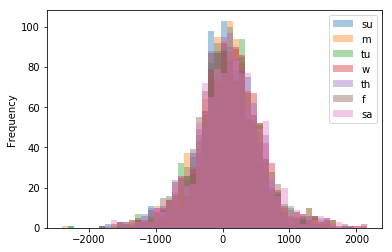

In [73]:
print('Residual Hist')
resids_df.plot(kind='hist', bins=50, alpha=0.4)

RMS by day


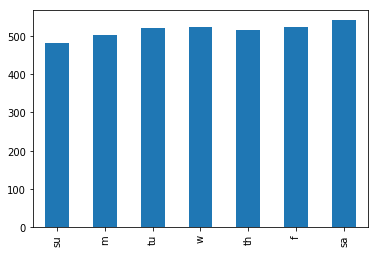

In [76]:
print('RMS by day')
resids_df.applymap(np.square).mean().apply(np.sqrt).plot(kind='bar')

MAE by day


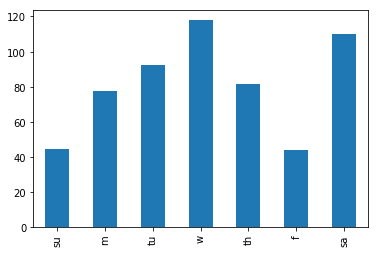

In [77]:
print('MAE by day')
resids_df.mean().plot(kind='bar')